In [1]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from my_modules import custom_f1_score


In [3]:
# Get the list of stopwords
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))

dataset = pd.read_csv("data/training_data.tsv.gz", sep="\t", header=None)
dataset.dropna(inplace=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andreas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = dataset.head(100000)

df.rename(columns={0: 'index', 1: 'title', 2: 'text', 3: 'labels'}, inplace=True)
df.drop('index', axis=1, inplace=True)

# Get the features
X  = df.drop('labels', axis=1)

# Start preprocessing the data:
# lower case all the data, remove all stop words (the, a, etc) and  other words that are from html (e.g <div><!div>)
X = X.applymap(lambda x: re.sub(r'<.*?>|[^\w\s]', '', x.lower())).applymap(lambda x: ' '.join([word for word in x.split() if word not in stopwords_list]))

# We will now concat title and text into one dataset
X = X["title"] + X["text"]
y = df['labels'].str.get_dummies(',')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


C:\Users\Andreas\AppData\Local\Temp\ipykernel_12908\1386238684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={0: 'index', 1: 'title', 2: 'text', 3: 'labels'}, inplace=True)
C:\Users\Andreas\AppData\Local\Temp\ipykernel_12908\1386238684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('index', axis=1, inplace=True)


In [6]:
# We want to get all the unique labels
unique_labels = y.drop_duplicates().reset_index(drop=True)
print(f"There are {len(unique_labels)} different labels. Let's see how often each combination occurs.")
print('Ideally we want to have at least one cluster for each combination later. We will experiment with the n_clusters parameter for kmeans.')

combination_counts = y.groupby(y.columns.tolist()).size().reset_index(name='count')
combination_counts

There are 15 different labels. Let's see how often each combination occurs.
Ideally we want to have at least one cluster for each combination later. We will experiment with the n_clusters parameter for kmeans.


,css,html,javascript,jquery,count
0,0,0,0,1,24273
1,0,0,1,0,29017
2,0,0,1,1,12388
3,0,1,0,0,9667
4,0,1,0,1,1340
5,0,1,1,0,3984
6,0,1,1,1,1506
7,1,0,0,0,7268
8,1,0,0,1,1137
9,1,0,1,0,1053


In [7]:
# Initialize the TfidfVectorizer - we normalize the text into numerical values
vectorizer = TfidfVectorizer()
pca = TruncatedSVD(n_components=3)

In [8]:
# Fit and transform the text data and apply dimensionality reduction
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

X_train_pca = pca.fit_transform(X_train_vectorized)
X_test_pca = pca.transform(X_test_vectorized)

In [9]:
# Initialize the Kmeans classifier
kmeans = KMeans(n_clusters=100)

# Train the Kmeans classifier
kmeans.fit(X_train_pca)

c:\Users\Andreas\.conda\envs\datamine\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=100)

In [10]:
# Assign labels for each centroid, take the label from the data point with the highest cosine similarity
centroids = kmeans.cluster_centers_

assigned_labels = []
for centroid in centroids:
    similarities = cosine_similarity([centroid], X_train_pca)
    closest_label_idx = np.argmax(similarities)
    assigned_label = y_train.loc[closest_label_idx].tolist()
    assigned_labels.append(assigned_label)

# Print the assigned labels for each centroid
for centroid, assigned_label in zip(centroids, assigned_labels):
    print(f"Centroid: {centroid}, Assigned Label: {assigned_label}")

Centroid: [0.21427038 0.15193945 0.02422326], Assigned Label: [1, 0, 1, 1]
Centroid: [ 0.12792514 -0.04763674 -0.06930213], Assigned Label: [0, 0, 0, 1]
Centroid: [0.10045272 0.01431254 0.05313181], Assigned Label: [0, 0, 1, 0]
Centroid: [ 0.15230308 -0.01278302  0.00110569], Assigned Label: [0, 0, 0, 1]
Centroid: [ 0.25285172 -0.0214023   0.12653272], Assigned Label: [0, 0, 1, 0]
Centroid: [ 0.05227646 -0.02044082 -0.02332366], Assigned Label: [0, 0, 1, 1]
Centroid: [ 0.08919453  0.13254681 -0.04255057], Assigned Label: [1, 1, 0, 0]
Centroid: [ 0.14867018 -0.04227811  0.04223124], Assigned Label: [0, 0, 1, 1]
Centroid: [ 0.14191554  0.0363     -0.10236309], Assigned Label: [0, 0, 0, 1]
Centroid: [0.15996573 0.09162058 0.14947366], Assigned Label: [1, 0, 0, 0]
Centroid: [ 0.22585502 -0.14689694  0.02498745], Assigned Label: [0, 0, 0, 1]
Centroid: [ 0.11579615  0.18676169 -0.04658608], Assigned Label: [1, 0, 0, 0]
Centroid: [0.19413946 0.02435923 0.08581063], Assigned Label: [1, 0, 1, 0

In [11]:
# Show which label combinations we already have as centroids
list(set(tuple(x) for x in assigned_labels))

[(0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 1),
 (1, 0, 1, 1),
 (1, 1, 0, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (1, 0, 1, 0),
 (1, 0, 0, 1),
 (1, 1, 0, 1),
 (1, 0, 0, 0),
 (0, 0, 1, 1)]

In [12]:
# Make predictions on the test set
y_pred_cluster = kmeans.predict(X_test_pca)

In [13]:
# Transform cluster index to tuple
y_pred = [assigned_labels[x] for x in y_pred_cluster]

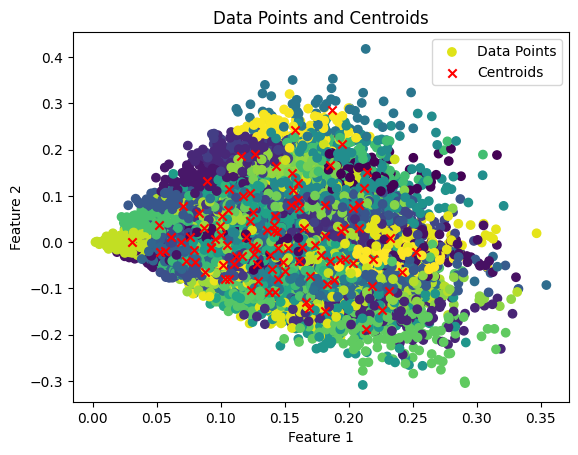

In [14]:
# Plot the data points and centroids
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_cluster)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Points and Centroids')
plt.legend(['Data Points', 'Centroids'])

# Show the plot
plt.show()

In [15]:
custom_f1 = custom_f1_score(y_pred, y_test)
print(f"The F1-score of our problem is {custom_f1}")

The F1-score of our problem is 0.683
